# ANALIZA PODATKOV
Na tem mestu bomo naredili analizo podatkov, ki so zbrani v csv datotekah v mapi podatki. Analizirali bomo po treh dejavnikih:
* analiza najstarejših prebivalcev in pričakovani življenjski dobi po državah,
* analiza najstarejših prebivalcev in gospodarskega razvoja držav,
* analiza najstarejših prebivalcev in naravnih zalog.


Naložimo pandas in omejimo velikot tabel na največ 15 vrstic.

In [326]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 15)
%matplotlib inline


Shranimo vse csv datoteke v nove spremenljivke.

In [327]:
najstarejsi_prebivalci = pd.read_csv("podatki/najstarejsi_prebivalci_po_drzavah.csv", index_col="Država")
pricakovana_zivljenjska_doba = pd.read_csv("podatki/pricakovana_zivljenjska_doba_po_drzavah.csv", index_col="Država")
GDP_po_drzavah = pd.read_csv("podatki/GDP_po_drzavah.csv")
podhranjenost_po_drzavah = pd.read_csv("podatki/podhranjenost_po_drzavah.csv", index_col="Država")
poraba_energije_po_drzavah = pd.read_csv("podatki/poraba_energije_po_drzavah.csv", index_col="Država")
obnovljiva_energija_po_drzavah = pd.read_csv("podatki/obnovljiva_energija_po_drzavah.csv", index_col="Država")
CO2_emisije_po_drzavah = pd.read_csv("podatki/CO2_emisije_po_drzavah.csv", index_col="Država")
kolicina_vode_po_drzavah = pd.read_csv("podatki/kolicina_vode_po_drzavah.csv", index_col="Država")


## Analiza po najstarejših prebivalcih in pričakovani življenjski dobi
V tem sklopu analize podatkov bomo primerjali starost najstarejših oseb po državah in pričakovani življenjski dobi po državah. Sprva bomo uredili tabelo najstarejših prebivalcev, nato ju bomo združili. Vsaka država bo imela moškega in žensko predstavnico, ki bosta izbrana na podlagi najdaljšega življenja (saj imajo nekatere države več kot dva predstavnika). Če država nima enega od predstavnikov, bomo zapisali le enega predstavnika. Hkrati se tudi lahko zgodi, da nekaterih držav ni navedenih v obeh tabelah podatkov. Te države izpustimo.  

In [328]:
# Najprej dodamo še en stolpec, ki predstavlja starost v decimalnem zapisu.
najstarejsi_prebivalci['Starost'] = najstarejsi_prebivalci['Starost (leta)'] + najstarejsi_prebivalci['Starost (dnevi)']/365
najstarejsi_prebivalci['Starost'] = najstarejsi_prebivalci['Starost'].round(2)
najstarejsi_prebivalci_vrstni_red = najstarejsi_prebivalci.sort_values(by=['Država', 'Spol', 'Starost (leta)', 'Starost (dnevi)'], ascending=[True, True, False, False])

# Za vsako kombinacijo države in spola vzamemo prvo vrstico (najstarejšo).
najstarejsi_prebivalci_urejena = najstarejsi_prebivalci_vrstni_red.groupby(['Država', 'Spol']).first().reset_index()

# Zdaj imamo za vsako državo in spol eno vrstico. Za vsako državo
# vzemimo največ dve vrstici (eno za vsak spol). Najprej dodamo pomožni stolpec za razvrstitev
# znotraj države (F nič, M prvi).
najstarejsi_prebivalci_urejena['Spol_razvrstitev'] = najstarejsi_prebivalci_urejena['Spol'].apply(lambda x: 0 if x == 'F' else 1)
najstarejsi_prebivalci_sortirana = najstarejsi_prebivalci_urejena.sort_values(by=['Država', 'Spol_razvrstitev'])

# Zdaj za vsako državo vzamemo največ dve vrstici.
najstarejsi_prebivalci_sortirana.groupby('Država').head(2).reset_index(drop=True)

# Odstranimo pomocni stolpec.
najstarejsi_prebivalci_sortirana = najstarejsi_prebivalci_sortirana.drop(columns=['Spol_razvrstitev'])
najstarejsi_prebivalci_sortirana

,Država,Spol,Datum rojstva,Datum smrti,Starost (leta),Starost (dnevi),Starost
0,Albania,F,10 May 1910,5 July 2021,111,56,111.15
1,Albania,M,13 February 1911,31 July 2020,109,169,109.46
2,Algeria,F,5 October 1890,26 March 20059,114,172,114.47
3,Algeria,M,29 July 1884,29 December 1995,111,153,111.42
4,Angola,F,17 June 1911,20 August 2023,112,64,112.18
...,...,...,...,...,...,...,...
167,United States,M,16 August 1882,25 April 1998,115,252,115.69
168,Uruguay,F,15 May 1904,29 July 2016,112,75,112.21
169,Uruguay,M,20 November 1911,18 March 2022,110,118,110.32
170,Venezuela,F,9 August 1911,12 December 2023,112,125,112.34


Sedaj združimo to tabelo s tabelo o pričakovani življenjski dobi. Združili jih bomo tako, da v nov stolpec dodamo indeks pričakovane življenjske dobe, ki je odvisen od države in spola osebe.

In [329]:
zdruzena_tabela = pd.merge(najstarejsi_prebivalci_sortirana, pricakovana_zivljenjska_doba, on='Država', how='left')

# Dodamo nov stolpec z indeksom pričakovane življenjske dobe.
zdruzena_tabela['Pričakovana življenjska doba po spolu'] = zdruzena_tabela.apply(
    lambda row: row['Pričakovana življenjska doba (ženske)'] if row['Spol'] == 'F' 
    else row['Pričakovana življenjska doba (moški)'] if row['Spol'] == 'M' 
    else None, 
    axis=1
)

zdruzena_tabela = zdruzena_tabela.sort_values(by=['Država', 'Spol'])
zdruzena_tabela = zdruzena_tabela.drop(columns=['Pričakovana življenjska doba', 'Pričakovana življenjska doba (ženske)', 'Pričakovana življenjska doba (moški)'])
zdruzena_tabela

,Država,Spol,Datum rojstva,Datum smrti,Starost (leta),Starost (dnevi),Starost,Pričakovana življenjska doba po spolu
0,Albania,F,10 May 1910,5 July 2021,111,56,111.15,81.74
1,Albania,M,13 February 1911,31 July 2020,109,169,109.46,78.12
2,Algeria,F,5 October 1890,26 March 20059,114,172,114.47,78.13
3,Algeria,M,29 July 1884,29 December 1995,111,153,111.42,75.30
4,Angola,F,17 June 1911,20 August 2023,112,64,112.18,67.54
...,...,...,...,...,...,...,...,...
167,United States,M,16 August 1882,25 April 1998,115,252,115.69,77.22
168,Uruguay,F,15 May 1904,29 July 2016,112,75,112.21,82.17
169,Uruguay,M,20 November 1911,18 March 2022,110,118,110.32,74.59
170,Venezuela,F,9 August 1911,12 December 2023,112,125,112.34,76.82


Z grafom predstavimo podatke spodnje tabele - starost s pričakovano življenjsko dobo po spolu.

In [330]:
tabela_pricakovane_zivljenjske = zdruzena_tabela[['Starost', 'Pričakovana življenjska doba po spolu']]
tabela_pricakovane_zivljenjske

,Starost,Pričakovana življenjska doba po spolu
0,111.15,81.74
1,109.46,78.12
2,114.47,78.13
3,111.42,75.30
4,112.18,67.54
...,...,...
167,115.69,77.22
168,112.21,82.17
169,110.32,74.59
170,112.34,76.82


<Axes: title={'center': 'Starost najstarejših prebivalcev glede na pričakovano življenjsko dobo'}, xlabel='Pričakovana življenjska doba', ylabel='Starost'>

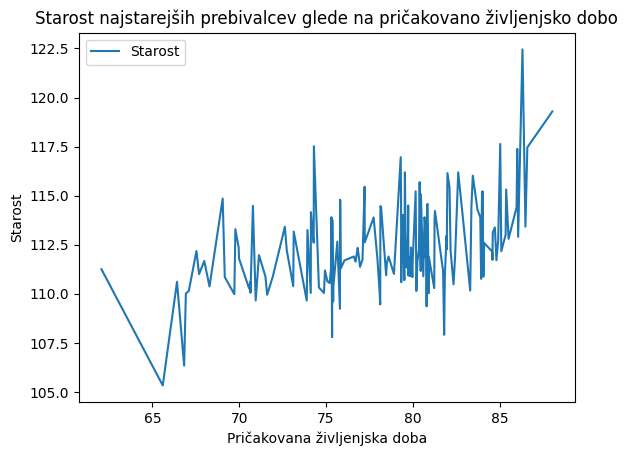

In [331]:
tabela_pricakovane_zivljenjske.groupby("Pričakovana življenjska doba po spolu").mean().plot(
    ylabel = "Starost", xlabel = "Pričakovana življenjska doba",
    title = "Starost najstarejših prebivalcev glede na pričakovano življenjsko dobo")

Opaženo je, da je korelacija med starostjo in pričakovano življenjsko dobo, saj graf narašča. 

## Analiza najstarejših prebivalcev in gospodarskega razvoja držav
V tem razdelku bomo analizirali podatke o starosti najstarejših prebivalcev in energetskem razvoju držav. Sklepamo, da bi lahko starost najstarejših prebivalcev lahko bila odvisna od razvitosti države, ki jo bomo v tem primeru merili s količino porabljene energije, odstotkom pridobljene obnovljive "zelene" energije, količino odvedenih CO2 emisij ter nenazadnje še z BDP-jem. S temi količina bomo pokrili kriterije kot so industrijska razvitost, razvoj države glede na moderne smernice ter na splošno gospodarki dejavniki. 


Sprva v tabeli najstarejših prebivalcev ohranimo le najstarejše predstavnike držav, saj v tem primeru nimamo razporejenih podatkov po spolu. Nato tabeli dodamo nove stolpce zgoraj navedenih količin.

In [332]:

# Resetirajmo indeks, da bo Država postal stolpec.
najstarejsi_prebivalci_reset = najstarejsi_prebivalci.reset_index()
# Uporabimo fukcijo drop_duplicates, da dobimo najstarejšega prebivalca v vsaki državi
najstarejsi_prebivalci_ekonomija_urejena = najstarejsi_prebivalci_reset.sort_values(by=['Starost'], ascending=False)
najstarejsi_prebivalci_ekonomija_sortirana = najstarejsi_prebivalci_ekonomija_urejena.drop_duplicates(subset='Država', keep='first')
najstarejsi_prebivalci_ekonomija = najstarejsi_prebivalci_ekonomija_sortirana.sort_values('Država')
najstarejsi_prebivalci_ekonomija = najstarejsi_prebivalci_ekonomija.set_index('Država')
najstarejsi_prebivalci_ekonomija

,Spol,Datum rojstva,Datum smrti,Starost (leta),Starost (dnevi),Starost
Država,,,,,,
Albania,F,10 May 1910,5 July 2021,111,56,111.15
Algeria,F,5 October 1890,26 March 20059,114,172,114.47
Angola,F,17 June 1911,20 August 2023,112,64,112.18
Antigua and Barbuda,F,23 January 1902,8 September 2012,110,229,110.63
Argentina,F,8 April 1907,28 June 202215,115,81,115.22
...,...,...,...,...,...,...
Ukraine,F,10 June 1906,19 August 2022,116,70,116.19
United Kingdom,F,21 August 1909,Living,116,6,116.02
United States,F,24 September 1880,30 December 1999,119,97,119.27


In [333]:
tabele = [poraba_energije_po_drzavah, obnovljiva_energija_po_drzavah, CO2_emisije_po_drzavah, GDP_po_drzavah]

# Začnemo z osnovno tabelo in jih potem postopoma združujemo.
zdruzena_tabela = najstarejsi_prebivalci_ekonomija.copy()
for tabela in tabele:
    zdruzena_tabela = pd.merge(zdruzena_tabela, tabela, on='Država', how='left')

# Izberemo želene stolpce.
tabela_ekonomije = zdruzena_tabela[['Starost', 'Odstotek porabe energije (svetovno)', 
                                   'Porabljena energija na prebivalca (letno)', 'Odstotek pridobljene obnovljive energije',
                                   'CO2 emisije na prebivalca (v tonah)', 'Delež svetovnega CO2 (v odstotkih)', 'GDP rast (v odstotkih)',
                                   'GDP na prebivalca (v dolarjih)', 'Delež svetovnega GDP (v odstotkih)']]

# Odstramimo vrstice z manjkajočimi vrednostmi.
tabela_ekonomije = tabela_ekonomije.dropna() 
tabela_ekonomije  

,Starost,Odstotek porabe energije (svetovno),Porabljena energija na prebivalca (letno),Odstotek pridobljene obnovljive energije,CO2 emisije na prebivalca (v tonah),Delež svetovnega CO2 (v odstotkih),GDP rast (v odstotkih),GDP na prebivalca (v dolarjih),Delež svetovnega GDP (v odstotkih)
0,111.15,0.0190,38590.0,100.0,1.59,0.01200,3.94,8375.0,0.0220
1,114.47,0.4100,57531.0,0.9,3.89,0.46000,4.10,5364.0,0.2300
2,112.18,0.0620,12000.0,76.0,0.57,0.05200,1.00,2308.0,0.0800
3,110.63,0.0018,117227.0,6.0,2.99,0.00072,3.86,21787.0,0.0019
4,115.22,0.6600,87325.0,34.0,4.05,0.48000,-1.61,14187.0,0.6100
...,...,...,...,...,...,...,...,...,...
95,114.50,1.1000,77422.0,42.0,5.53,1.25000,5.11,12814.0,1.0500
96,116.19,0.6200,79941.0,17.0,3.23,0.34000,5.32,4737.0,0.1700
97,116.02,1.4100,123441.0,47.0,5.00,0.88000,0.34,49224.0,3.1800
98,119.27,16.7700,293979.0,23.0,14.21,12.60000,2.89,80706.0,26.1100


Sedaj primerjavo vse štiri količine s starostjo najstarejših prebivalcev. Najprej začnemo s porabljeno energijo.

<Axes: title={'center': 'Starost najstarejših prebivalcev glede na porabljeno energijo'}, xlabel='Porabljena energija na prebivalca (letno)', ylabel='Starost'>

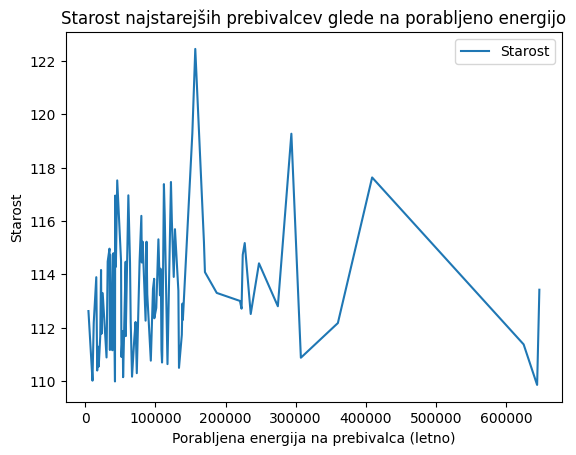

In [334]:
tabela_ekonomije_energija_urejena = tabela_ekonomije.sort_values(by=['Porabljena energija na prebivalca (letno)'], ascending=True)
tabela_ekonomije_energija_urejena[['Porabljena energija na prebivalca (letno)', 'Starost']].groupby('Porabljena energija na prebivalca (letno)').mean().plot(
    ylabel = "Starost", xlabel = "Porabljena energija na prebivalca (letno)",
    title = "Starost najstarejših prebivalcev glede na porabljeno energijo")


Iz grafa se opazi, da trend morda še nekoliko narašča do 100.000 porabljene energije, nato pa se začnejo anomalije.
Poglejmo si še tortni diagram porabljene energije.

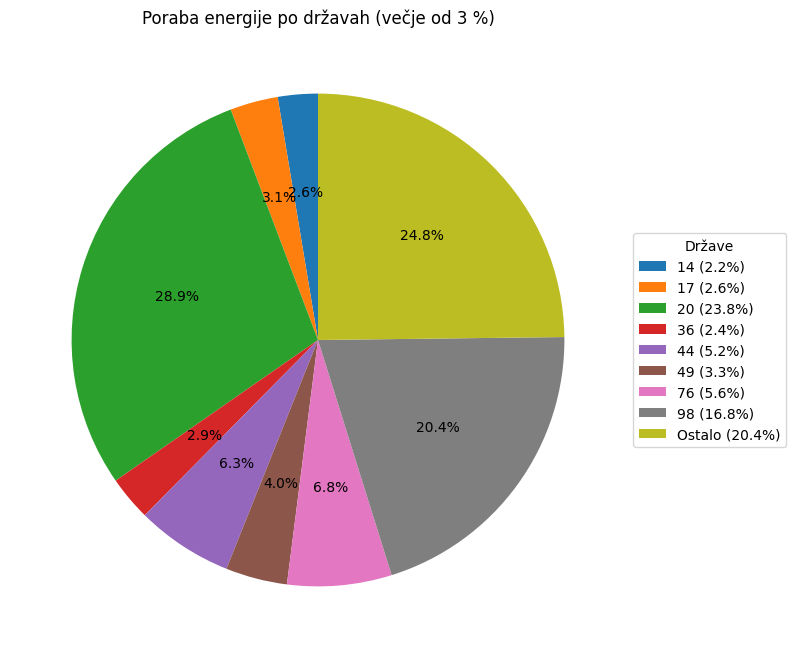

In [335]:
# Določimo mejo za prikazovanje podatkov in združimo podatke majhnih držav.
meja_odstotka = 2.0
filtrirani_podatki = tabela_ekonomije['Odstotek porabe energije (svetovno)'].copy()
majhne_drzave = filtrirani_podatki < meja_odstotka
vsota_majhnih_drzav = filtrirani_podatki[majhne_drzave].sum()
filtrirani_podatki = filtrirani_podatki[~majhne_drzave]  # Odstranimo mahne države.
if vsota_majhnih_drzav > 0:
    filtrirani_podatki['Ostalo'] = vsota_majhnih_drzav 

# Narišite tortni diagram s prikazom procentov samo za večje deleže.
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(
    filtrirani_podatki,
    autopct=lambda p: f'{p:.1f}%' if p > meja_odstotka else '',
    startangle=90
)

# Dodamo legendo na desno stran. 
plt.legend(
    wedges,
    [f'{label} ({p:.1f}%)' for label, p in zip(filtrirani_podatki.index, filtrirani_podatki)],
    title="Države",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)
plt.title('Poraba energije po državah (večje od 3 %)')
plt.show()


Tortni diagram prikazuje, da porabljena energija ni povsem odvisna od številčnosti prebivalstva. Kot primer lahko navedemo Indijo, ki je trenutno po populaciji največja država na svetu, a hkrati si lasti še le četrto mesto po porabi energije. Če sklepamo, da je starost najstarejših prebivalcev odvisna tudi od populacije, delež porabljene energije na državo ne vpliva skoraj nič na starost najstarejših prebivalcev.

Sedaj si oglejmo podatke o obnovljivi energiji.

<Axes: title={'center': 'Starost najstarejših prebivalcev glede na obnovljivo energijo'}, xlabel='Pridobljena obnovljiva enegija v (%)', ylabel='Starost'>

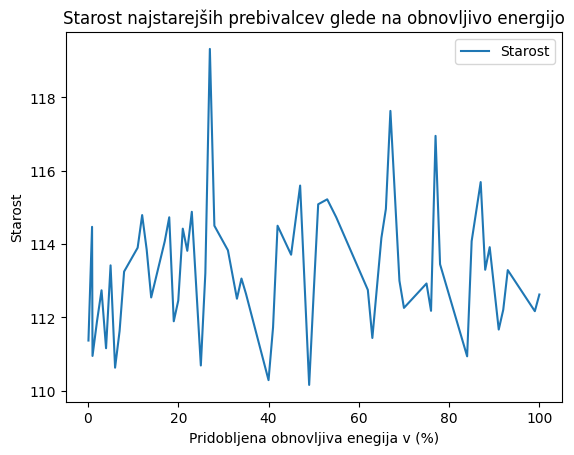

In [336]:
tabela_ekonomije_obnovljiva_energija_urejena = tabela_ekonomije.sort_values(by=['Odstotek pridobljene obnovljive energije'], ascending=True)
tabela_ekonomije_obnovljiva_energija_urejena[['Odstotek pridobljene obnovljive energije', 'Starost']].groupby('Odstotek pridobljene obnovljive energije').mean().plot(
    ylabel = "Starost", xlabel = "Pridobljena obnovljiva enegija v (%)",
    title = "Starost najstarejših prebivalcev glede na obnovljivo energijo")

V tem grafu je vidno, da ni nobene povezave med starostjo najstarejših prebivalcev in pridobljeno obnovljivo energijo. To je seveda posledica tega, da je v manjših državah zagotovo lažje doseči odstotek energije pridobljene iz obnovljivih virov kot v večjih državah. Hkrati pa je seveda starost najstarejših prebivalcev po državah lahko tudi posledica številčnosti prebivalstva - v državi z več prebivalstva je večja možnost, da bo imela več ljudi, ki bodo dosegli zelo veliko starost.
Oglejmo si spodnji diagram.

In [ ]:
# Ustvarimo nov stolpec z zaokroženimi vrednostmi obnovljive energije na desetice. Tako bo lažje 
# predstaviti podatke v stolpičnem diagramu.
tabela_ekonomije_obnovljiva_energija_urejena = tabela_ekonomije_obnovljiva_energija_urejena.reset_index(drop=True)
tabela_ekonomije_obnovljiva_energija_urejena['Obnovljiva energija (zaokožena)'] = tabela_ekonomije_obnovljiva_energija_urejena['Odstotek pridobljene obnovljive energije'].round(-1)
tabela_ekonomije_obnovljiva_energija_urejena = tabela_ekonomije_obnovljiva_energija_urejena[['Starost', 'Obnovljiva energija (zaokožena)']]
tabela_ekonomije_obnovljiva_energija_urejena  

,Starost,Obnovljiva energija (zaokožena)
0,111.37,0.0
1,114.47,0.0
2,110.95,0.0
3,111.90,0.0
4,112.74,0.0
...,...,...
83,112.17,100.0
84,109.85,100.0
85,114.28,100.0
86,111.15,100.0


<Axes: title={'center': 'Število držav glede na pridobljeno obnovljivo energijo'}, xlabel='Pridobljena obnovljiva energija (zaokrožena na 10%)', ylabel='Število držav'>

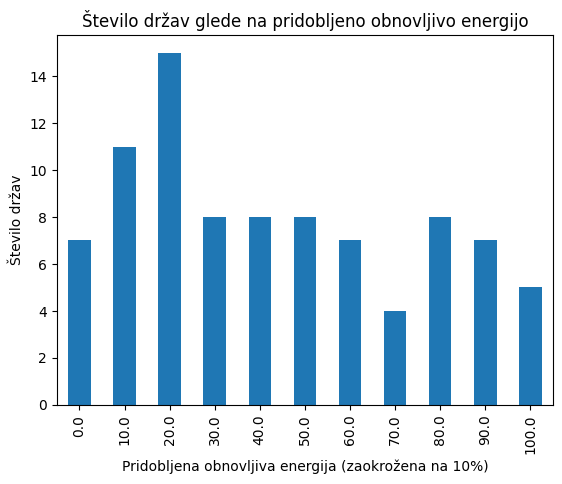

In [338]:
stevilo_obnovljiva_energija_zaokrozeno = tabela_ekonomije_obnovljiva_energija_urejena['Obnovljiva energija (zaokožena)'].value_counts().sort_index()
stevilo_obnovljiva_energija_zaokrozeno.plot(
    kind='bar',
    xlabel = "Pridobljena obnovljiva energija (zaokrožena na 10%)",
    ylabel = "Število držav",
    title = "Število držav glede na pridobljeno obnovljivo energijo")

Stolpični diagram prikazuje, da ima večina držav manj kot 50% pridobljene obnovljive energije. To nakazuje, da ta spremenljivka ni še povsem primerna za analiziranje, saj so določene države še v procesu razvijanja.
Poglejmo si še grafa CO2 emisij in BDP-ja.  

<Axes: title={'center': 'Starost najstarejših prebivalcev glede na CO2 emisije'}, xlabel='CO2 emisije na prebivalca (v tonah)', ylabel='Starost'>

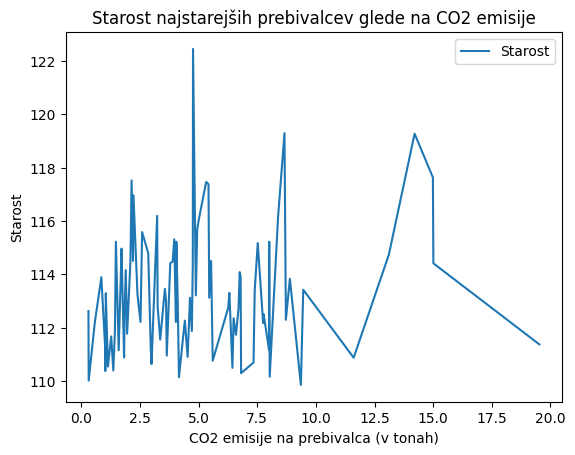

In [339]:
tabela_ekonomije_CO2_urejena = tabela_ekonomije.sort_values(by=['CO2 emisije na prebivalca (v tonah)'], ascending=True)
tabela_ekonomije_CO2_urejena[['CO2 emisije na prebivalca (v tonah)', 'Starost']].groupby('CO2 emisije na prebivalca (v tonah)').mean().plot(
    ylabel = "Starost", xlabel = "CO2 emisije na prebivalca (v tonah)",
    title = "Starost najstarejših prebivalcev glede na CO2 emisije")

CO2 emisije nimajo povezave z starostjo.

<Axes: title={'center': 'Starost najstarejših prebivalcev glede na BDP'}, xlabel='BDP na prebivalca (v dolarjih)', ylabel='Starost'>

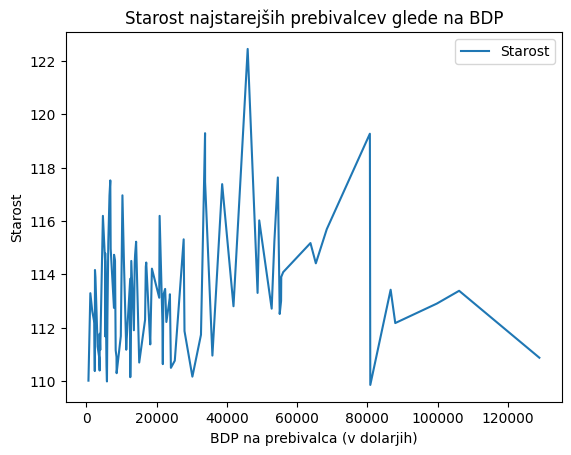

In [340]:
tabela_ekonomije_GDP_urejena = tabela_ekonomije.sort_values(by=['GDP na prebivalca (v dolarjih)'], ascending=True)
tabela_ekonomije_GDP_urejena[['GDP na prebivalca (v dolarjih)', 'Starost']].groupby('GDP na prebivalca (v dolarjih)').mean().plot(
    ylabel = "Starost", xlabel = "BDP na prebivalca (v dolarjih)",
    title = "Starost najstarejših prebivalcev glede na BDP")

<Axes: title={'center': 'Starost najstarejših prebivalcev glede na BDP rast'}, xlabel='BDP rast (v odstotkih)', ylabel='Starost'>

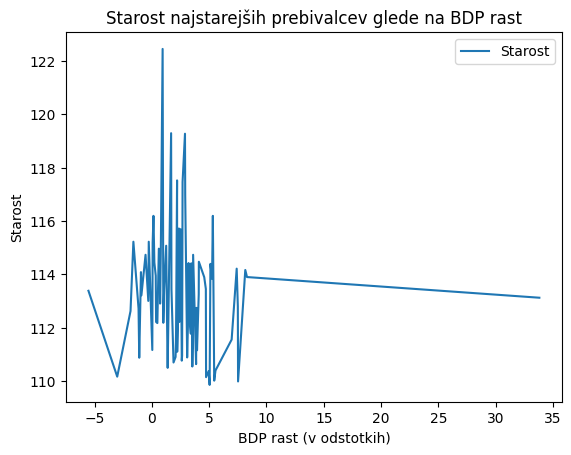

In [341]:
tabela_ekonomije_GDP_rast_urejena = tabela_ekonomije.sort_values(by=['GDP rast (v odstotkih)'], ascending=True)
tabela_ekonomije_GDP_rast_urejena[['GDP rast (v odstotkih)', 'Starost']].groupby('GDP rast (v odstotkih)').mean().plot(
    ylabel = "Starost", xlabel = "BDP rast (v odstotkih)",
    title = "Starost najstarejših prebivalcev glede na BDP rast")

Iz zadnjih dveh grafov sklepamo, da je vidna povezava s starostjo prebivalstva. V prvem grafu se opazi, da je graf ločen na dva dela - prvi del je do okoli 30.000 dolarjev, drugi pa od 30.000 dolarjev naprej. Prvi del je zagotovo manjši od drugega, klub temu pa je povezavo med BDP-jem in starostjo težko posplošiti. V drugem grafu pa je vidno, da države s pozitivno ekonomsko rastjo dosegajo višje starosti najstarejših prebivalcev.

Lahko zaključimo, da imajo gospodarski dejavniki majhen vpliv na starost najstarejših prebivalcev. Iz analize podatkov o BDPju sledi, da se vsekakor vidi povezava med gospodarsko rastjo ter starostjo najstarejših prebivalcev. To bi lahko povezali z dejstvom, da večji razvoj države vpliva na dobrobit starosti prebivalcev. Hkrati smo v tem delu opazili, da industrijski razvoj (analiziran s podatki o CO2 emisijah in porabljeni energiji) in razvoj modernih smernic (podatki o obnovljivi energiji) nimata skoraj nič vpliva na starost najstarejših prebivalcev. 
Oglejmo si še zadnji del te analize.

## Analiza po prebivalcih in naravnih zalogah
V tem delu bomo primerjali podatke najstarejših prebivalcev s podatki o populaciji, podatki o količini vode ter podatki o podhranjenosti prebivalstva. Cilj tega odseka je poiskati, če je kakšna povezava z naravnimi viri in starostjo najstarejših prebivalcev. Oglejmo si naslednjo tabelo.

In [ ]:
# Sestavimo tabelo z vsemi količinami. Podatke o populaciji vzamemo iz tabele o BDPju.
GDP_po_drzavah = GDP_po_drzavah.reset_index(drop=True)
prebivalstvo = GDP_po_drzavah[['Država','Populacija']]
skupna_tabela_2 = pd.merge(najstarejsi_prebivalci_ekonomija, prebivalstvo, on='Država', how='left')
skupna_tabela_2 = pd.merge(skupna_tabela_2, kolicina_vode_po_drzavah, on='Država', how='left')
skupna_tabela_2 = pd.merge(skupna_tabela_2, podhranjenost_po_drzavah, on='Država', how='left')
skupna_tabela_2 = skupna_tabela_2[[
    'Država', 'Starost', 'Populacija', 'Porabljena količina vode na prebivalca (dnevno)', 
    'Delež podhranjenega prebivalstva (v odstotkih)']]
skupna_tabela_2

,Država,Starost,Populacija,Porabljena količina vode na prebivalca (dnevno),Delež podhranjenega prebivalstva (v odstotkih)
0,Albania,111.15,2811655.0,1177.0,6.9
1,Algeria,114.47,46164219.0,669.0,3.8
2,Angola,112.18,36749906.0,100.0,23.6
3,Antigua and Barbuda,110.63,93316.0,361.0,NaN
4,Argentina,115.22,45538401.0,2480.0,4.7
...,...,...,...,...,...
96,Ukraine,116.19,37732836.0,592.0,3.3
97,United Kingdom,116.02,68682962.0,350.0,NaN
98,United States,119.27,343477335.0,3732.0,NaN
99,Uruguay,112.21,3388081.0,3070.0,NaN


Sedaj si oglejmo graf populacije s starostjo najstarejših prebivalcev.

<Axes: title={'center': 'Starost najstarejših prebivalcev glede na populacijo'}, xlabel='Populacija', ylabel='Starost'>

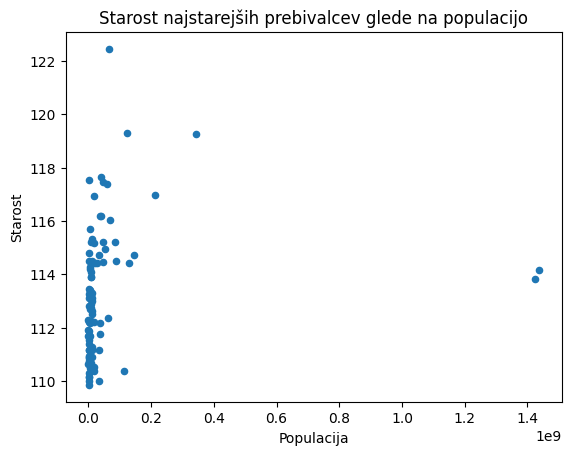

In [343]:
# Tabelo šele zdaj uredimo tako, da vrstice z manjkajočimi vrednostmi odstranimo in uredimo po populaciji.
tabela_grafa_populacije = skupna_tabela_2[['Država', 'Starost', 'Populacija']]
tabela_grafa_populacije = tabela_grafa_populacije.sort_values(by='Populacija', ascending=True)
tabela_grafa_populacije = tabela_grafa_populacije.dropna()
tabela_grafa_populacije.plot(
    x='Populacija', y='Starost', kind='scatter',
    xlabel = "Populacija",
    ylabel = "Starost",
    title = "Starost najstarejših prebivalcev glede na populacijo"
)

Vidno je, da so največje starosti najstarejših prebivalcev dosežene na pri vrednostih okoli 100 milijonov prebivalcev. Povezave med velikostjo populacije in starostjo pa torej ni, saj graf ne prikazuje lepega trenda. Oglejmo si še zadnja dva grafa.

<Axes: title={'center': 'Starost najstarejših prebivalcev glede na porabljeno količino vode'}, xlabel='Porabljena količina vode na prebivalca (dnevno)', ylabel='Starost'>

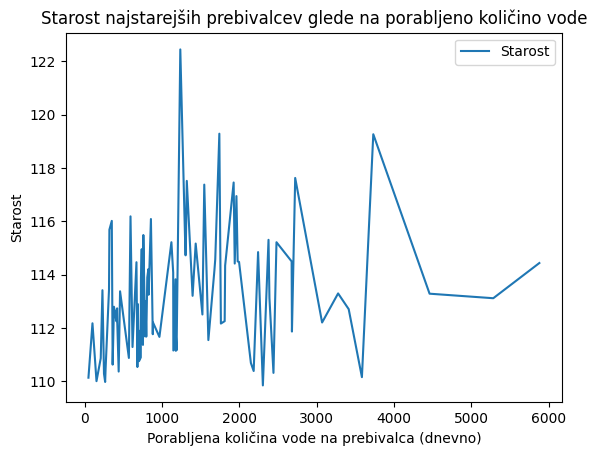

In [344]:
tabela_grafa_kolicine_vode = skupna_tabela_2[['Starost', 'Porabljena količina vode na prebivalca (dnevno)']]
tabela_grafa_kolicine_vode = tabela_grafa_kolicine_vode.sort_values(by='Porabljena količina vode na prebivalca (dnevno)', ascending=True)
tabela_grafa_kolicine_vode = tabela_grafa_kolicine_vode.dropna()
tabela_grafa_kolicine_vode.groupby('Porabljena količina vode na prebivalca (dnevno)').mean().plot(
    xlabel = "Porabljena količina vode na prebivalca (dnevno)",
    ylabel = "Starost",             
    title = "Starost najstarejših prebivalcev glede na porabljeno količino vode"
)

Iz grafa je opazno, da države z manjšo porabo vode dosegajo manjšo starost najstarejših prebivalcev. Odvisnost je težko posplošiti, saj za večje količine porabljene vode starost ne narašča.

<Axes: title={'center': 'Starost najstarejših prebivalcev glede na podhranjenost'}, xlabel='Delež podhranjenega prebivalstva (v odstotkih)', ylabel='Starost'>

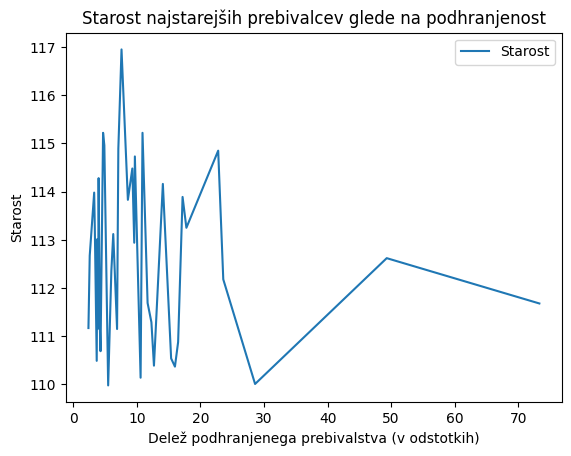

In [345]:
tabela_grafa_podhranjenost = skupna_tabela_2[['Starost', 'Delež podhranjenega prebivalstva (v odstotkih)']]
tabela_grafa_podhranjenost = tabela_grafa_podhranjenost.sort_values(by='Delež podhranjenega prebivalstva (v odstotkih)', ascending=True)
tabela_grafa_podhranjenost = tabela_grafa_podhranjenost.dropna()
tabela_grafa_podhranjenost.groupby('Delež podhranjenega prebivalstva (v odstotkih)').mean().plot(
    xlabel = "Delež podhranjenega prebivalstva (v odstotkih)",
    ylabel = "Starost",             
    title = "Starost najstarejših prebivalcev glede na podhranjenost"
)

Graf nakazuje, da države z manjšim ideksom dosegajo v povprečju večje vrednosti starosti najstarejših prebivalcev. Seveda je treba privzeti, da se v tem grafu obravnavajo primeri držav, ki nadpovpečno presegajo mejo podhranjenosti.

### Zaključek
Iz prvega dela analize sledi, da je pričakovna življenjska doba v splošnem povezana s starostjo najstarejših prebivalcev. Nadaljna analiza podatkov pa razkrije, da industrijski razvoj zagotovo ne vpliva v taki velikosti kot pričakovana življenjska doba. Po drugi strani je opazno, da gospodarski razvoj vpliva na starost, prav tako je mogoče opaziti, da naravna zaloga (v tem primeru merjena s količina vode, ki je glavni vir preživetja) ima vpliv vsaj do neke osnovne meje količine vode, ki jo človek potrebuje za življenje. Analiza podhranjenosti prebivalstva pa prav tako razkriva povezavo s starostjo najstarejših prebivalcev.

Kot zadnje bi omenil, da je ta analiza podatkov narejena le na statističnih podatkih in ni primerna za popolno posplošitev.